### Natural Language Processing

Gabriel Aldrich S. Calubayan

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import copy
import string
import seaborn as sns
import numpy as np
from scipy import stats
import nltk

Genius Lyrics Dataset from: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information/data

Relevant columns are the following (nonexhaustive):
* `title`
* `tag`
* `artist`
* `lyrics`
* `language`

In [44]:
# loading the filtered dataset
old_df = pd.read_csv('./filceb_lyrics.csv', engine='python')
df = old_df.copy()

**Checking missing values**

In [45]:
title_null_count = df["title"].isnull().sum()
tag_null_count = df["tag"].isnull().sum()
artist_null_count = df["artist"].isnull().sum()
lyrics_null_count = df["lyrics"].isnull().sum()
language_null_count = df["language"].isnull().sum()

print("Number of null values:")
print("Title:", title_null_count)
print("Tag:", tag_null_count)
print("Artist:", artist_null_count)
print("Lyrics:", lyrics_null_count)
print("Language:", language_null_count)


Number of null values:
Title: 0
Tag: 0
Artist: 0
Lyrics: 0
Language: 0


**Lyrics cleanup - Ensuring Formatting consistency**

In [46]:
# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['lyrics'] = df['lyrics'].apply(remove_punctuation)

# Function to remove newlines
def remove_newlines(text):
    return text.replace('\n', ' ')

# Apply the function to the "lyrics" column
df['lyrics'] = df['lyrics'].apply(remove_newlines)

# Lowercase all lyrics
def lowercase_text(text):
    return text.lower()
df['lyrics'] = df['lyrics'].apply(lowercase_text)

# Remove song part markers e.g., [CHORUS], [Verse 1], (Loonie)
def remove_bracket_parenthesis_text(text):
    return re.sub(r'\[.*?\]|\(.*?\)', '', text)

df['lyrics'] = df['lyrics'].apply(remove_bracket_parenthesis_text)

def remove_song_parts(text):
    song_parts = ["intro", "chorus", "verse", "bridge", "coda", "refrain"] # we can add more later
    for word in song_parts:
        text = text.replace(word, '')
    return text
df['lyrics'] = df['lyrics'].apply(lambda x: remove_song_parts(x))

def contains_non_alphanumeric(text):
    # Check if the text contains only alphanumeric ASCII characters and whitespace
    return not bool(re.match(r'^[a-zA-Z0-9\s]+$', text))

# Apply the function to the 'lyrics' column
df['contains_non_alphanumeric'] = df['lyrics'].apply(contains_non_alphanumeric)

# Filter out rows where 'contains_non_alphanumeric' is True
df = df[df['contains_non_alphanumeric'] == False]

# Drop the 'contains_non_alphanumeric' column
df = df.drop(columns=['contains_non_alphanumeric'])

df.head

<bound method NDFrame.head of                          title  tag             artist  year  views  \
0                     All star  rap       Enchant boyz  2012     27   
1                Balak ni Syke  rap             Gloc-9  2012   2313   
2               Apatnapungbara  rap             Gloc-9  2012   2423   
3                        Silup  rap             Gloc-9  2012   1392   
5       New Life Song Part Two  rap  R1 one 6 souljhaz  2012     21   
...                        ...  ...                ...   ...    ...   
7287          PANGHABANG-BUHAY  pop              Bradz  2022      7   
7288                     Totoo  pop             NOBITA  2022    176   
7289    Willow Smith Refine EP  rap        Crid Taylor  2022      2   
7290       ISSA VIBE REFINE EP  rap        Crid Taylor  2022      2   
7291  SATURDAY NIGHT REFINE EP  rap        Crid Taylor  2022      3   

                features                                             lyrics  \
0             {Lil_john}  ako nang una

**Stopword removal and tokenization**

Filipino stopwords from [this repository](https://github.com/stopwords-iso/stopwords-tl). Cebuano stopwords from [this repository](https://github.com/digitalheir/cebuano-dictionary-js/tree/master)

In [47]:
from nltk.tokenize import word_tokenize

# remove Filipino stopwords in songs with "fil" language value
fil_sw_bank = open("./genediazjr-tagalog.txt", 'r', encoding='utf-8')
fil_stopwords = [line.strip() for line in fil_sw_bank]

def remove_fil_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word not in fil_stopwords]
    return ' '.join(cleaned_words)

df.loc[df['language'] == 'fil', 'lyrics'] = df[df['language'] == 'fil']['lyrics'].apply(remove_fil_stopwords)

# remove Cebuano stopwords in songs with "ceb" language value
ceb_sw_bank = open("./cebuanostopwords.txt", 'r', encoding='utf-8')
ceb_stopwords = [line.strip() for line in ceb_sw_bank]

def remove_ceb_stopwords(text):
    words = word_tokenize(text.split()) # tokenization
    cleaned_words = [word for word in words if word not in ceb_stopwords]
    return ' '.join(cleaned_words)

df.loc[df['language'] == 'ceb', 'lyrics'] = df[df['language'] == 'ceb']['lyrics'].apply(remove_fil_stopwords)
df.head


<bound method NDFrame.head of                          title  tag             artist  year  views  \
0                     All star  rap       Enchant boyz  2012     27   
1                Balak ni Syke  rap             Gloc-9  2012   2313   
2               Apatnapungbara  rap             Gloc-9  2012   2423   
3                        Silup  rap             Gloc-9  2012   1392   
5       New Life Song Part Two  rap  R1 one 6 souljhaz  2012     21   
...                        ...  ...                ...   ...    ...   
7287          PANGHABANG-BUHAY  pop              Bradz  2022      7   
7288                     Totoo  pop             NOBITA  2022    176   
7289    Willow Smith Refine EP  rap        Crid Taylor  2022      2   
7290       ISSA VIBE REFINE EP  rap        Crid Taylor  2022      2   
7291  SATURDAY NIGHT REFINE EP  rap        Crid Taylor  2022      3   

                features                                             lyrics  \
0             {Lil_john}  nang unang b

### Recommendations

- **Bank of Filipino and Cebuano stopwords verified by academic institutions** - This might help increase the accuracy of the model. This project is only using the *best/most complete* available stopword bank online
- **Stemming and lemmatization** - this could be useful in normalizing words and removing common suffixes. However, existing libraries (e.g., nltk) do not have these in-built for Filipino and Cebuano (as of May 2024). It is recommended to perform this to help enhance the model in the future, but this will be outside the scope of this project.
- **Have more samples/song entries for other genres, and more genres in general** - The dataset used in this project has a lot more `pop` entries versus other `tag` values. More entries for other genres might improve the performance of the model

### Visualization

**Song counts**

In [48]:
# fil/ceb counts
language_counts = df['language'].value_counts()

print(language_counts)

language
fil    5387
ceb      72
Name: count, dtype: int64


tag
pop        3827
rap         884
rock        495
rb          181
misc         52
country      20
Name: count, dtype: int64


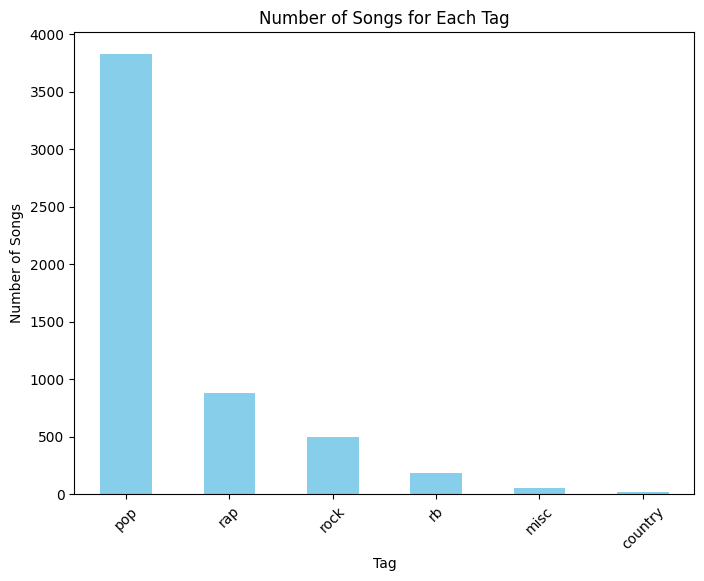

In [49]:
# tag/genre counts
tag_counts = df['tag'].value_counts()
print(tag_counts)

plt.figure(figsize=(8, 6))
tag_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Songs for Each Tag')
plt.xlabel('Tag')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.show()

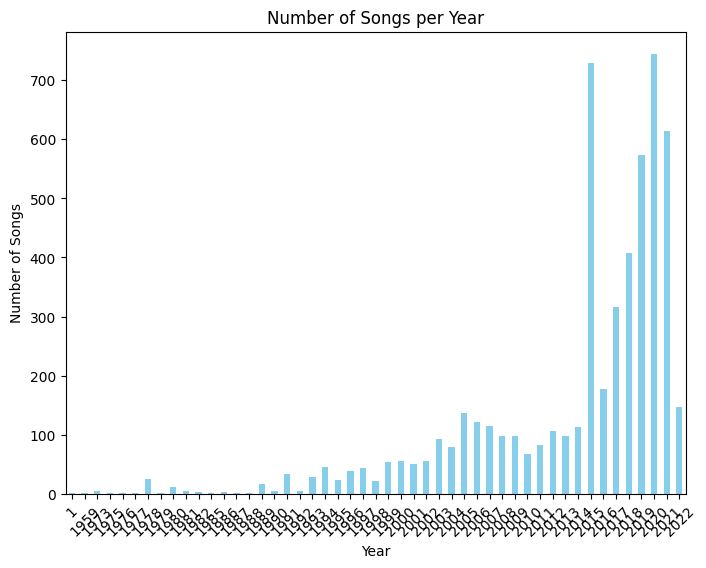

In [50]:
# Count the number of songs for each year
year_counts = df['year'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(8, 6))
year_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Songs per Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.show()

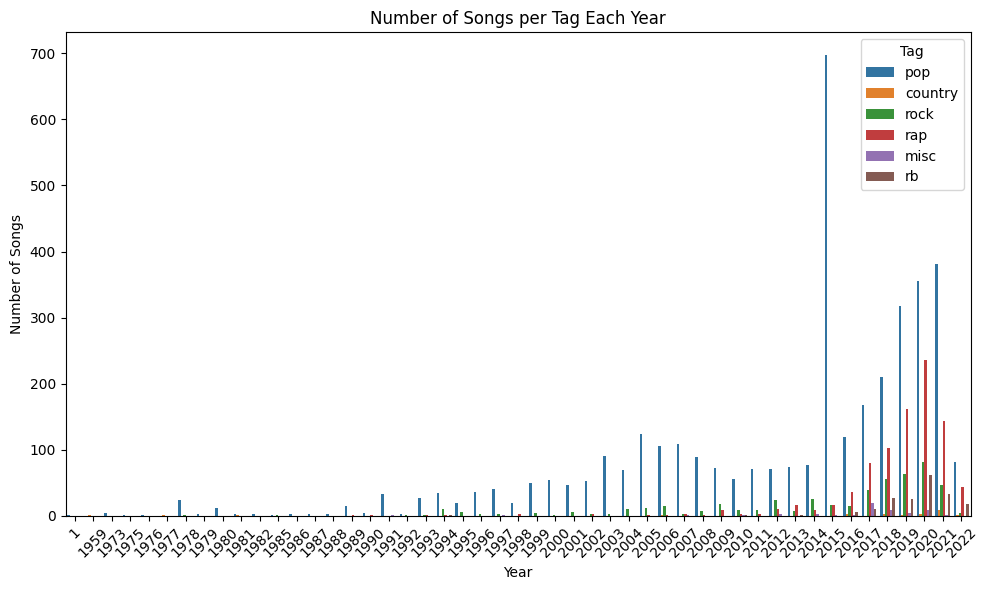

In [51]:
# Plot the side-by-side countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year', hue='tag')
plt.title('Number of Songs per Tag Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.legend(title='Tag')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Song lengths**

Average song length:  126.37
tag
country    114.100000
misc        91.596154
pop        104.914293
rap        232.011312
rb         153.038674
rock        98.000000
Name: lyric_length, dtype: float64


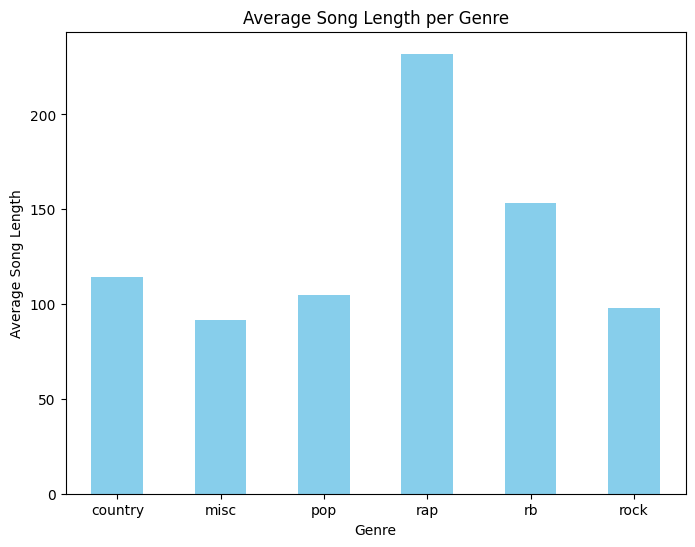

In [52]:
# Compute the length of each lyric
df['lyric_length'] = df['lyrics'].apply(lambda x: len(x.split()))

average_song_length = df['lyric_length'].mean()
print("Average song length: ", float(f"{average_song_length:.2f}"))

average_lyric_length_per_tag = df.groupby('tag')['lyric_length'].mean()
print(average_lyric_length_per_tag)

# Plot the bar graph
plt.figure(figsize=(8, 6))
average_lyric_length_per_tag.plot(kind='bar', color='skyblue')
plt.title('Average Song Length per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Song Length')
plt.xticks(rotation=0)
plt.show()

In [53]:
# export data to new csv
df.to_csv('processed_lyrics.csv', index=False)